In [ ]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import candel
from candel import SPEED_OF_LIGHT

from utils import *

from scipy.stats import norm
from astropy.cosmology import FlatLambdaCDM
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

root = "/Users/rstiskalek/Projects/CANDEL/results/CH0"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path)

2025-06-20 10:28:54 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-20 10:28:54 indices of zero width: [44]
2025-06-20 10:28:54 found zero-width prior at index 44. Setting it to 0.


### Hubble diagrams Cepheid-only Hubble diagrams

In [3]:
# Read-in the data
mu_host_r2 = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "mu_host")
mu_host_unif = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "mu_host")

mu_host_r2_mean = np.mean(mu_host_r2, axis=0)
mu_host_unif_mean = np.mean(mu_host_unif, axis=0)

mu_host_r2_err = np.std(mu_host_r2, axis=0)
mu_host_unif_err = np.std(mu_host_unif, axis=0)

cz = data["czcmb_cepheid_host"]
cz_err = np.ones_like(cz) * 270

# Prepare the Hubble diagram plots
czrange = np.linspace(450, 5100, 1000)
zrange = czrange / SPEED_OF_LIGHT

cosmo_SH0ES = FlatLambdaCDM(H0=73.04, Om0=0.3)
mu_SH0ES = cosmo_SH0ES.distmod(czrange / SPEED_OF_LIGHT).value

cosmo_Planck = FlatLambdaCDM(H0=67.4, Om0=0.3)
mu_Planck = cosmo_Planck.distmod(czrange / SPEED_OF_LIGHT).value

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_22219/2815319929.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


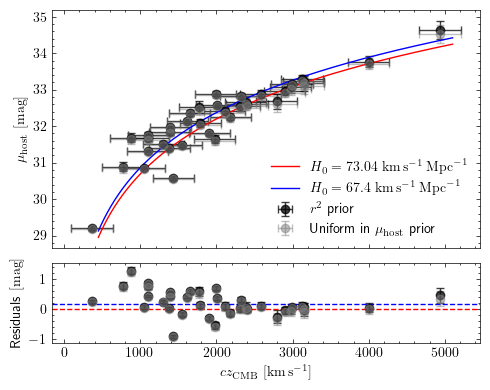

In [4]:
# Compute SH0ES model predictions at the data cz points
mu_SH0ES_cz = np.interp(cz, czrange, mu_SH0ES)
mu_Planck_cz = np.interp(cz, czrange, mu_Planck)
mu_Planck_residual = mu_Planck_cz - mu_SH0ES_cz

# Start figure with two panels: main plot and residuals
with plt.style.context("science"):
    fig, (ax_main, ax_resid) = plt.subplots(
        2, 1, figsize=(5, 4),
        gridspec_kw={"height_ratios": [3, 1],}, sharex=True
    )

    # Main panel
    ax_main.errorbar(
        cz, mu_host_r2_mean, xerr=cz_err, yerr=mu_host_r2_err,
        fmt="o", color="black", label=r"$r^2$ prior", capsize=3, alpha=0.75
    )
    ax_main.errorbar(
        cz, mu_host_unif_mean, xerr=cz_err, yerr=mu_host_unif_err,
        fmt="o", color="gray", label=r"Uniform in $\mu_{\rm host}$ prior", capsize=3, alpha=0.5
    )
    ax_main.plot(
        czrange, mu_SH0ES, color="red", label=r"$H_0 = 73.04~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )
    ax_main.plot(
        czrange, mu_Planck, color="blue", label=r"$H_0 = 67.4~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )

    ax_main.set_ylabel(r"$\mu_{\rm host} ~ [\mathrm{mag}]$")
    ax_main.legend()

    # Residual panel
    resid_r2 = mu_host_r2_mean - mu_SH0ES_cz
    resid_unif = mu_host_unif_mean - mu_SH0ES_cz
    ax_resid.errorbar(
        cz, resid_r2, yerr=mu_host_r2_err,
        fmt="o", color="black", capsize=3, alpha=0.75
    )
    ax_resid.errorbar(
        cz, resid_unif, yerr=mu_host_unif_err,
        fmt="o", color="gray", capsize=3, alpha=0.5
    )

    # Planck-SH0ES residual line
    ax_resid.axhline(mu_Planck_residual.mean(), color="blue", ls="--")

    ax_resid.axhline(0, color="red", ls="--")
    ax_resid.set_xlabel(r"$c z_{\rm CMB} ~ [\mathrm{km}\,\mathrm{s}^{-1}]$")
    ax_resid.set_ylabel(r"Residuals $[\mathrm{mag}]$")

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/mu_host_cz_residual.pdf", dpi=500, bbox_inches="tight")
    fig.show()

### Comparison of Cepheid-only distance

SH0ES_fiducial.hdf5: H0, M_B, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_r2_prior.hdf5: M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_mu_uniform.hdf5: M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Removed no burn in
Removed no burn in
Removed no burn in
2025-06-20 10:32:30 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/anchor_distances.pdf


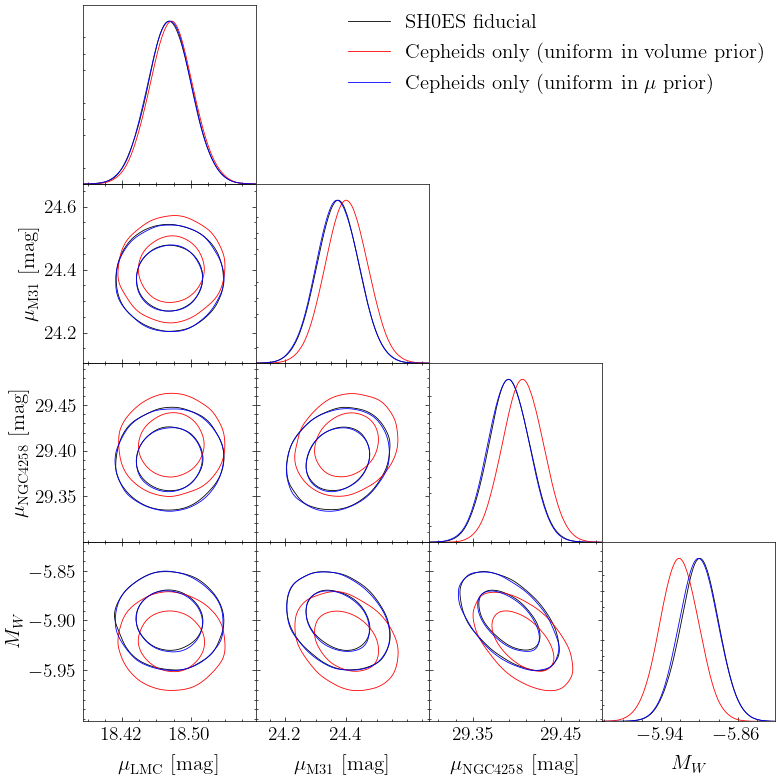

In [5]:
fnames = [
    "SH0ES_fiducial.hdf5",
    "Cepheid_distances_r2_prior.hdf5",
    "Cepheid_distances_mu_uniform.hdf5",
]
labels = [
    "SH0ES fiducial",
    r"Cepheids only (uniform in volume prior)",
    r"Cepheids only (uniform in $\mu$ prior)",
]

fnames = [join(root, fname) for fname in fnames]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["mu_LMC", "mu_M31", "mu_N4258", "M_W"],
    labels=labels,
    filled=False,
    fontsize=18,
    filename="/Users/rstiskalek/Downloads/anchor_distances.pdf",
    )

### Cepheid-host galaxies distance comparison

0.044466123


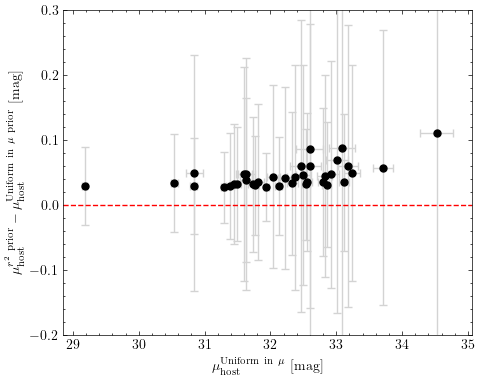

In [8]:
samples_r2 = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "mu_host")
samples_unif = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "mu_host")

ntot = 37

X = {f"mu_{i}": samples_unif[:, i] for i in range(ntot)}
Y = {f"mu_{i}": samples_r2[:, i] for i in range(ntot)}

x_mean = np.asarray([np.mean(X[f"mu_{i}"]) for i in range(ntot)])
x_err = np.asarray([np.std(X[f"mu_{i}"]) for i in range(ntot)])

dx_mean = np.asarray([np.mean(Y[f"mu_{i}"]) - np.mean(X[f"mu_{i}"]) for i in range(ntot)])
dx_err = np.asarray([np.sqrt(np.var(Y[f"mu_{i}"]) + np.var(X[f"mu_{i}"])) for i in range(ntot)])

print(dx_mean.mean())

with plt.style.context("science"):
    plt.figure(figsize=(5, 4))
    plt.errorbar(x_mean, dx_mean, xerr=x_err, yerr=dx_err, fmt='o', color='black',
                 ecolor='lightgray',  capsize=3, ms=5)
    plt.axhline(0, color="red", linestyle="--", label="No difference")
    plt.xlabel(r"$\mu_{\rm host}^{\mathrm{Uniform~in~}\mu} ~ [\mathrm{mag}]$")
    plt.ylabel(r"$\mu_{\rm host}^{r^2~\mathrm{prior}} - \mu_{\rm host}^{\mathrm{Uniform~in~}\mu~\mathrm{prior}} ~ [\mathrm{mag}]$")
    plt.ylim(-0.2, 0.3)
    plt.tight_layout()
    plt.savefig("/Users/rstiskalek/Downloads/mu_host.pdf", bbox_inches='tight')

    plt.show()


### Cepheid-only inferred $H_0$ 

SH0ES_fiducial.hdf5: H0, M_B, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_redshift_r2_PVcov.hdf5: H0, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v
Removed no burn in
Removed no burn in
2025-06-16 13:11:11 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/anchor_distances.pdf


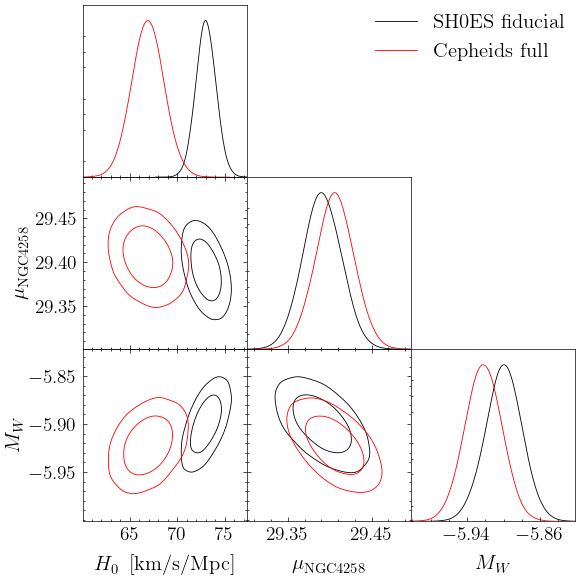

In [ ]:
fnames = [
    "SH0ES_fiducial.hdf5",
    "Cepheid_distances_redshift_r2_PVcov.hdf5",
]
labels = [
    "SH0ES fiducial",
    # r"Cepheids only (uniform in volume prior)",
    # r"Cepheids only (uniform in $\mu$ prior)",
    r"Cepheids full",
]

fnames = [join(root, fname) for fname in fnames]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["H0", "mu_N4258", "M_W"],
    labels=labels,
    filled=False,
    fontsize=18,
    filename="/Users/rstiskalek/Downloads/anchor_distances.pdf",
    )

### Comparison corner-plot

Cepheid_H0_Vext_sigma_v.hdf5: H0, M_W, Vext, Vext_b, Vext_ell, Vext_mag, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v
Cepheid_H0_PV_covmat_scaled.hdf5: A_covmat, H0, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v
Cepheid_H0_C15_MNR.hdf5: H0, M_W, Vext, Vext_b, Vext_ell, Vext_mag, Z_W, b_W, beta, dZP, mean_OH_all, mean_OH_per_host, mean_logP_all, mean_logP_per_host, mean_std_OH, mean_std_logP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v, std_OH_all, std_OH_per_host, std_logP_all, std_logP_per_host
Removed no burn in
Removed no burn in
Removed no burn in
2025-06-20 11:36:38 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/H0_corner.pdf


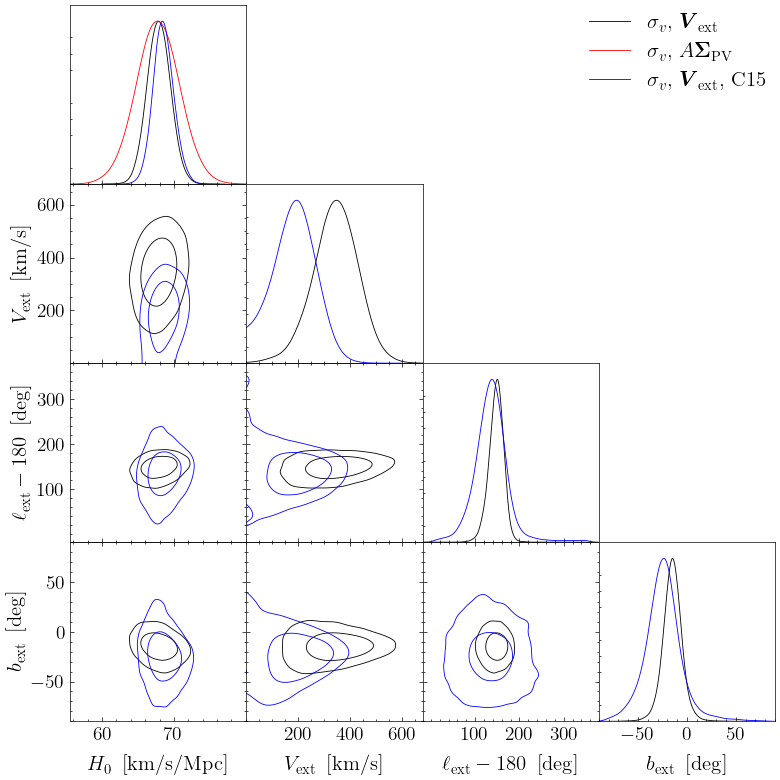

In [126]:
fnames = [
    "Cepheid_H0_Vext_sigma_v.hdf5",
    "Cepheid_H0_PV_covmat_scaled.hdf5",
    "Cepheid_H0_C15_MNR.hdf5",
    ]

labels = [
    r"$\sigma_v,\,\boldsymbol{V}_{\rm ext}$",
    r"$\sigma_v,\,A \boldsymbol{\Sigma}_{\rm PV}$",
    r"$\sigma_v,\,\boldsymbol{V}_{\rm ext}$, C15",
    ]



fnames = [join(root, fname) for fname in fnames]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["H0", "Vext_mag", "Vext_ell", "Vext_b",],
    labels=labels,
    filled=False,
    apply_ell_offset=True,
    ell_range=[None, None],
    filename="/Users/rstiskalek/Downloads/H0_corner.pdf",
    fontsize=18,
    )

### C15 all-parameters

Cepheid_H0_C15_MNR.hdf5: H0, M_W, Vext, Vext_b, Vext_ell, Vext_mag, Z_W, b_W, beta, dZP, mean_OH_all, mean_OH_per_host, mean_logP_all, mean_logP_per_host, mean_std_OH, mean_std_logP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v, std_OH_all, std_OH_per_host, std_logP_all, std_logP_per_host
Removed no burn in
2025-06-20 11:42:52 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/C15_corner.pdf


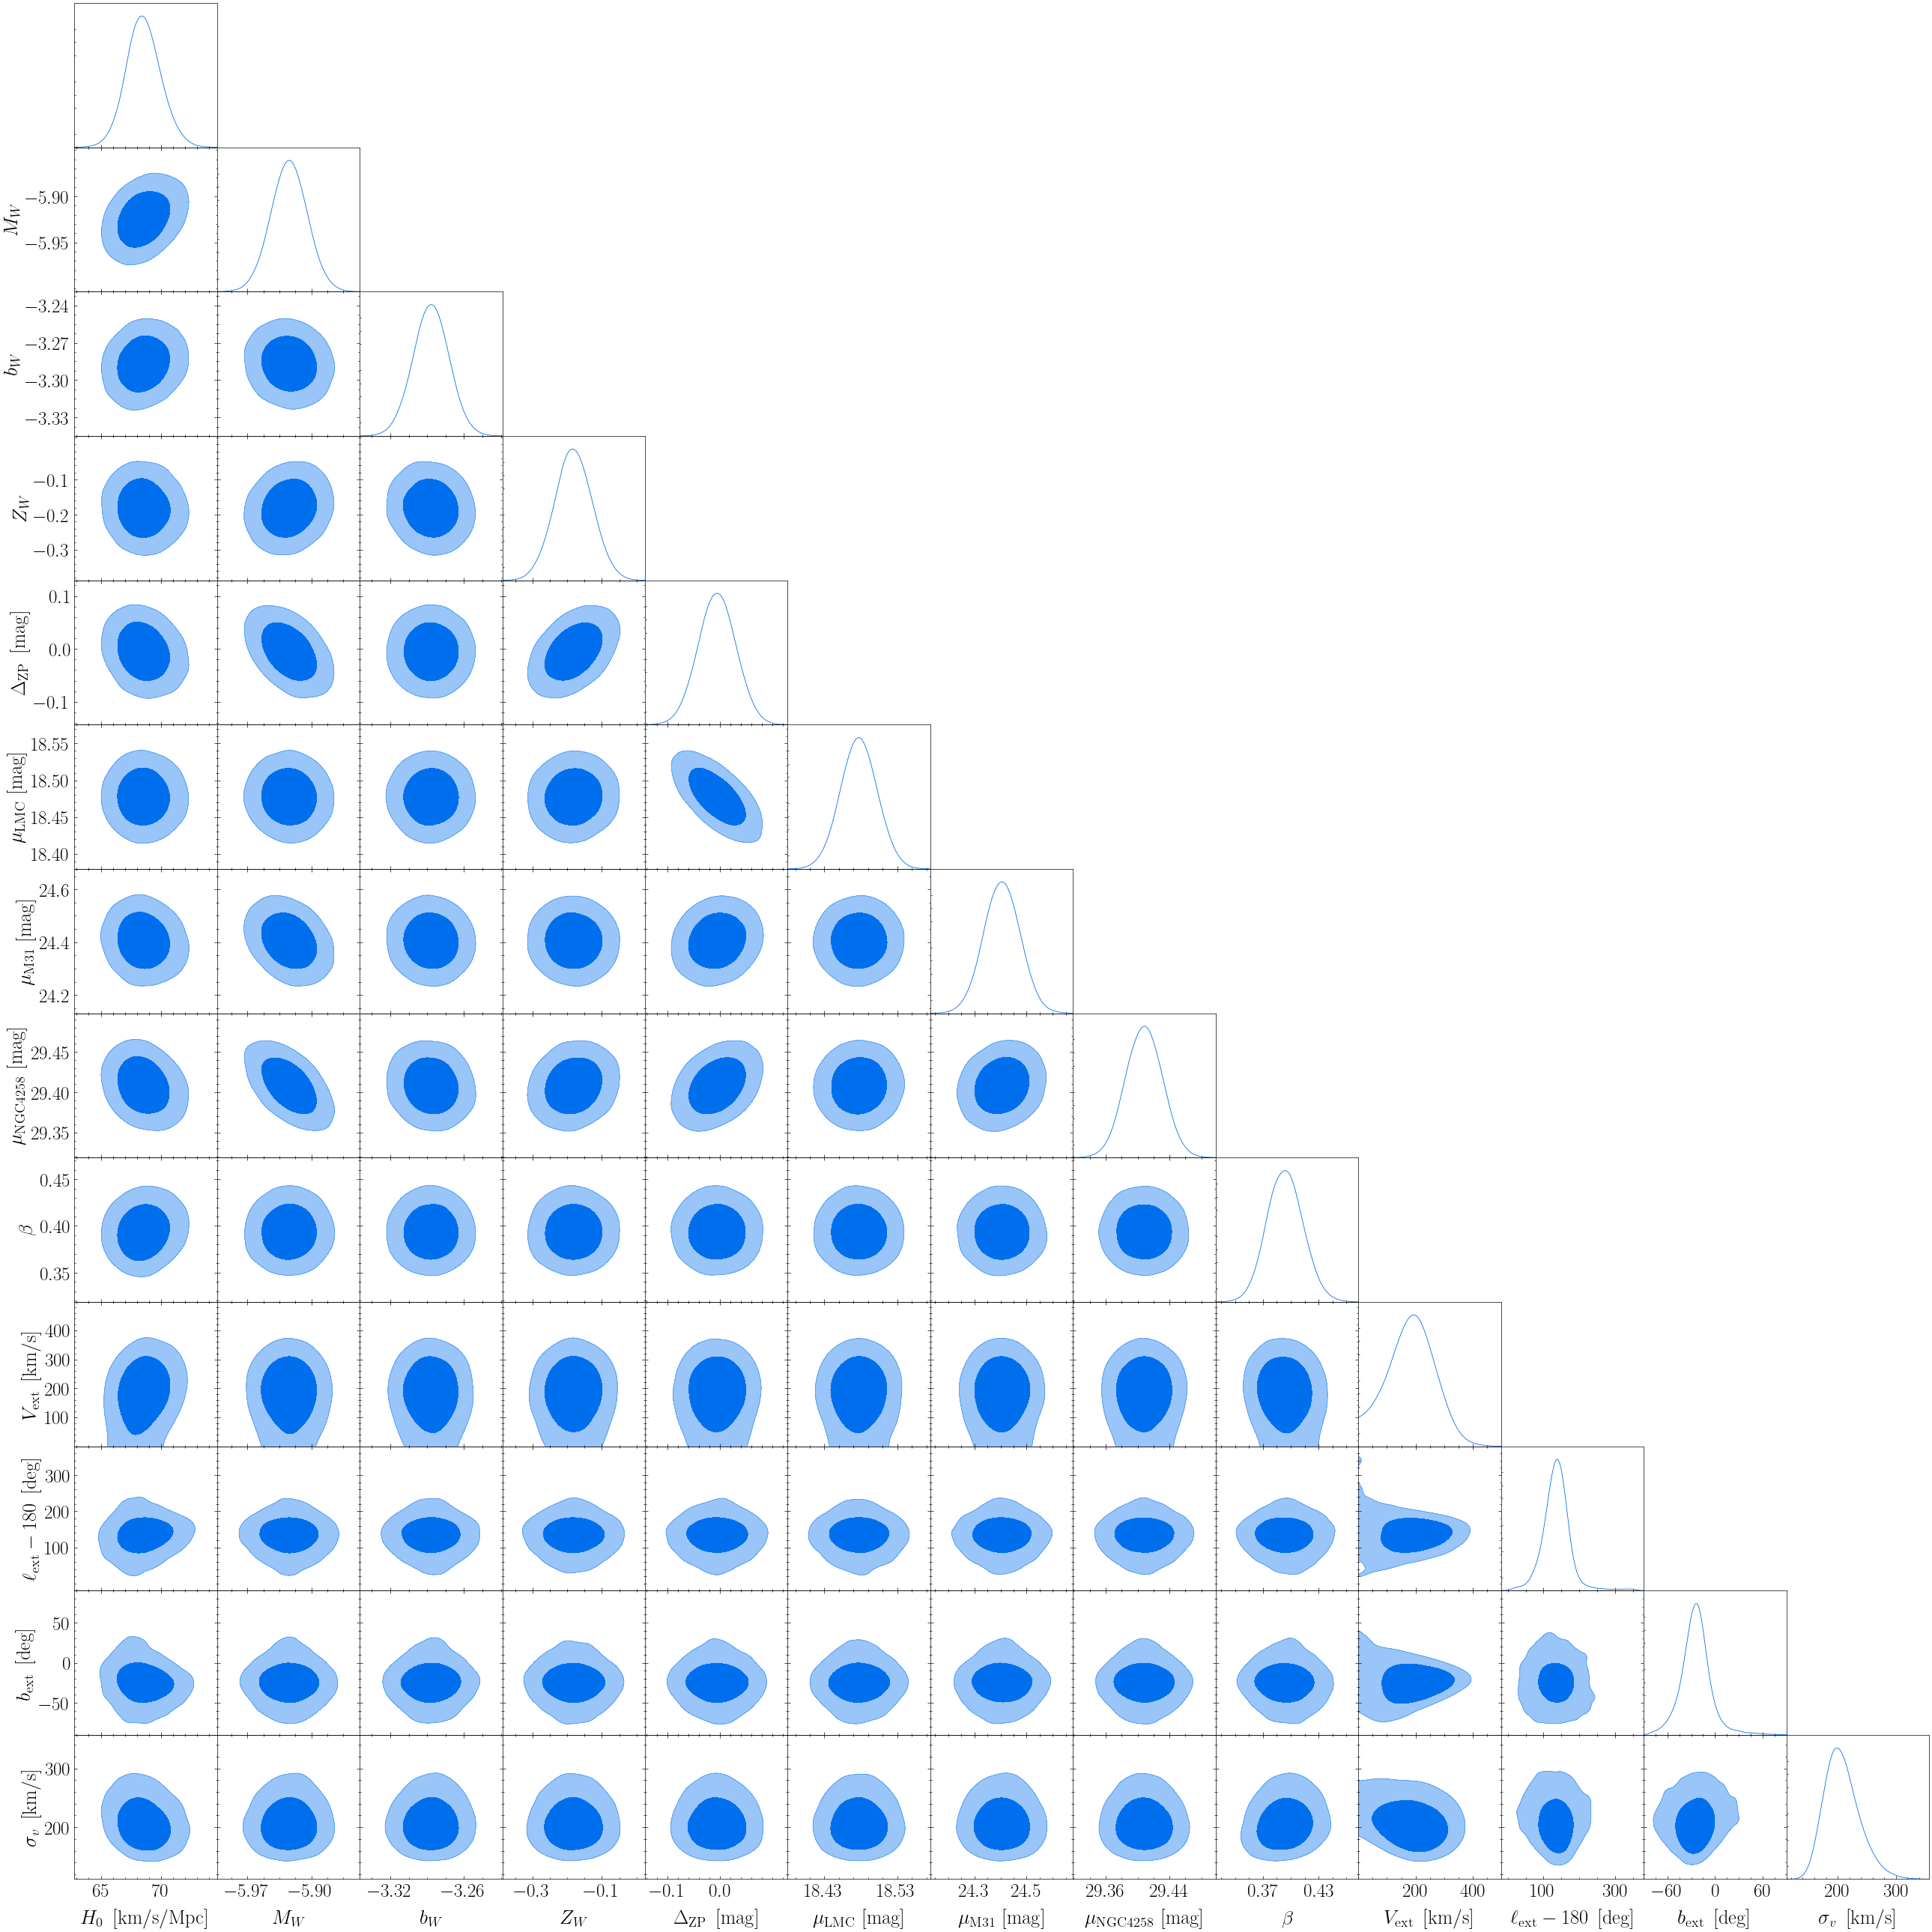

In [133]:
fnames = [
    "Cepheid_H0_C15_MNR.hdf5",
    ]

labels = None

fnames = [join(root, fname) for fname in fnames]

candel.plot_corner_from_hdf5(
    fnames,
    keys=["H0", "M_W", "b_W", "Z_W", "dZP", "mu_LMC", "mu_M31", "mu_N4258", "beta", "Vext_mag", "Vext_ell", "Vext_b", "sigma_v"],
    labels=labels,
    apply_ell_offset=True,
    ell_range=[None, None],
    filename="/Users/rstiskalek/Downloads/C15_corner.pdf",
    fontsize=22,
    )

### Comparison of all inferred $H_0$ values

In [35]:
fnames = [
    "Cepheid_H0_sigma_v.hdf5",
    "Cepheid_H0_Vext_sigma_v.hdf5",
    "Cepheid_H0_PV_covmat.hdf5",
    "Cepheid_H0_PV_covmat_scaled.hdf5",
    "Cepheid_H0_C15.hdf5",
]
labels = [
    r"$\sigma_v$",
    r"$\sigma_v,\,\boldsymbol{V}_{\rm ext}$",
    r"$\sigma_v,\,\boldsymbol{\Sigma}_{\rm PV}$",
    r"$\sigma_v,\,A \boldsymbol{\Sigma}_{\rm PV}$",
    r"$\sigma_v,\,\boldsymbol{V}_{\rm ext}$, C15",
    # r"Cepheids only (uniform in volume prior)",
    # r"Cepheids only (uniform in $\mu$ prior)",
    # r"Cepheids full",
]


samples = [read_samples(root, fname, "H0") for fname in fnames]

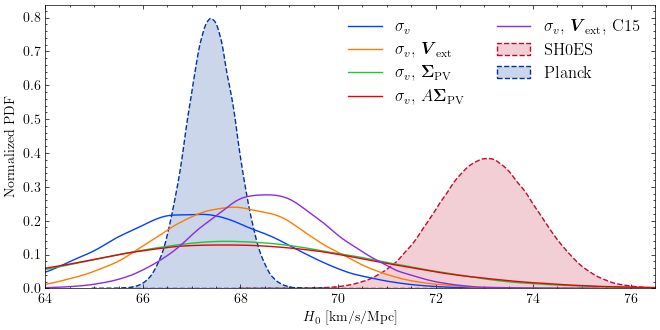

In [84]:
fig_width = 6.8  # in inches
fig_height = 3.5

filtered_palette = sns.color_palette("bright")
# filtered_palette = set1_palette[2:]  # skip red (0) and blue (1)

with plt.style.context("science"):
    plt.figure(figsize=(fig_width, fig_height))

    for i in range(len(samples)):
        sns.kdeplot(
            samples[i],
            label=labels[i],
            fill=False,
            color=filtered_palette[i % len(filtered_palette)]
        )

    sns.kdeplot(
        norm(73.04, 1.04).rvs(size=500000),
        label="SH0ES",
        fill=True,
        alpha=0.2,
        ls="--",
        color="#BF0A30",
        zorder=-1,
    )
    sns.kdeplot(
        norm(67.4, 0.5).rvs(size=500000),
        label="Planck",
        fill=True,
        alpha=0.2,
        ls="--",
        color="#003399",
        zorder=-1,
    )

    plt.xlabel(r"$H_0 ~ [\mathrm{km}/\mathrm{s}/\mathrm{Mpc}]$")
    plt.ylabel("Normalized PDF")
    plt.legend(ncol=2, fontsize="large")
    plt.xlim(64, 76.5)
    plt.tight_layout()
    plt.savefig("/Users/rstiskalek/Downloads/H0_comparison.pdf", dpi=500, bbox_inches="tight")
    plt.show()